<img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Microsoft%20Malware%20Prediction/Microsoft_logo.png" width="600" height="170">
<h1><center>Microsoft Malware Prediction</center></h1>
<h2><center>Extended EDA</center></h2>

### This is the second part of the EDA you can see the [first part here](https://www.kaggle.com/dimitreoliveira/malware-detection-eda-and-lgbm)
* On the first part we saw that some features may not be useful for our models, so I won't use them on this analysis:
    * Columns with more than 40% null values:  **PuaMode, Census_ProcessorClass, Census_InternalBatteryType, Census_IsFlightingInternal, Census_ThresholdOptIn, Census_IsWIMBootEnabled**.
    * Columns with high cardinality:  **AvSigVersion, DefaultBrowsersIdentifier, AVProductStatesIdentifier, CityIdentifier, OsBuildLab, Census_OEMNameIdentifier, Census_OEMModelIdentifier, Census_ProcessorModelIdentifier, Census_FirmwareManufacturerIdentifier, Census_FirmwareVersionIdentifier**. I'll leave AvSigVersion in because I need it to the time-series analysis.
    * Some features have a very similar distribution between labels: **AppVersion, OsBuild, Census_OSBuildNumber, Census_PrimaryDiskTotalCapacity, Census_InternalPrimaryDisplayResolutionHorizontal, Census_InternalBatteryNumberOfCharges**.
    
### Content
* [Feature type EDA](#Feature-type-EDA).
* [Binary features EDA](#Binary-features-EDA).
* [Numerical features EDA](#Numerical-features-EDA).
* [Train/validation split EDA](#Train/validation-split-EDA).

In [1]:
import gc
import dask
import dask.dataframe as dd
import warnings
import cufflinks
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

gc.enable()
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

use_columns = ['MachineIdentifier', 'ProductName', 'EngineVersion', 'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductsInstalled', 
               'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform', 
               'Processor', 'OsVer', 'OsSuite', 'OsPlatformSubRelease', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier', 
               'SmartScreen', 'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 
               'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_ChassisTypeName', 
               'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_PowerPlatformRoleName', 
               'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSBuildRevision', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 
               'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_OSWUAutoUpdateOptionsName', 'Census_IsPortableOperatingSystem', 
               'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_IsFlightsDisabled', 'Census_FlightRing', 'Census_IsSecureBootEnabled', 
               'Census_IsVirtualDevice', 'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer', 
               'Wdft_RegionIdentifier']

numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

### Load data

In [3]:
train = dd.read_csv('../input/microsoft-malware-prediction/train.csv', dtype=dtypes, usecols=(use_columns + ['HasDetections'])).compute()
test = dd.read_csv('../input/microsoft-malware-prediction/test.csv', dtype=dtypes, usecols=use_columns).compute()

## Feature type EDA

In [4]:
# Create statistics for train and test sets.
def dataset_stats(dataset):
    stats = []
    for col in dataset.columns:
        if col != 'HasDetections':
            n_unique = dataset[col].nunique()
            col_type = dataset[col].dtype
            if col_type in numerics:
                col_type = 'Numerical'
            if col_type == 'category':
                col_type = 'Categorical'
            if n_unique == 2:
                col_type = 'Binary'
            if n_unique == 1:
                col_type = 'Constant'
            stats.append((col, n_unique, col_type))

    return pd.DataFrame(stats, columns=['Feature', 'Unique values', 'Type']).sort_values('Unique values', ascending=False)

train_stats = dataset_stats(train)
test_stats = dataset_stats(test)

In [5]:
# Join statistics from train and test into a single dataframe.
join_stats = train_stats.copy()
join_stats.columns = ['Feature', 'Train Unique values', 'Train Type']
join_stats['Test Unique values'] = 0
join_stats['Test Type'] = '???'

for index, row in join_stats.iterrows():
    for test_index, test_row in test_stats.iterrows():
        if row['Feature'] == test_row['Feature']:
            join_stats.loc[index, 'Test Unique values'] = test_row['Unique values']
            join_stats.loc[index, 'Test Type'] = test_row['Type']

join_stats['% changed'] = (1 - (join_stats['Test Unique values'] / join_stats['Train Unique values'])) * 100
join_stats = join_stats[['Feature', 'Train Unique values', 'Test Unique values', '% changed', 'Train Type', 'Test Type']]
join_stats

,Feature,Train Unique values,Test Unique values,% changed,Train Type,Test Type
0,MachineIdentifier,8921483,7853253,11.973682,Categorical,Categorical
32,Census_SystemVolumeTotalCapacity,536848,509175,5.154718,Numerical,Numerical
3,AvSigVersion,8531,9357,-9.682335,Categorical,Categorical
34,Census_TotalPhysicalRAM,3446,3700,-7.370865,Numerical,Numerical
37,Census_InternalPrimaryDisplayResolutionVertical,1552,1570,-1.159794,Numerical,Numerical
36,Census_InternalPrimaryDiagonalDisplaySizeInInches,785,803,-2.292994,Numerical,Numerical
39,Census_OSVersion,469,475,-1.279318,Categorical,Categorical
23,IeVerIdentifier,303,294,2.970297,Numerical,Numerical
12,GeoNameIdentifier,292,289,1.027397,Numerical,Numerical
42,Census_OSBuildRevision,285,294,-3.157895,Numerical,Numerical


In [6]:
print('------Train------')
print(join_stats['Train Type'].value_counts())
print('------Test------')
print(join_stats['Test Type'].value_counts())

------Train------
Categorical    25
Numerical      20
Binary         16
Name: Train Type, dtype: int64
------Test------
Categorical    25
Numerical      20
Binary         16
Name: Test Type, dtype: int64


### Evaluating the dataset feature types, we should drop the constant features and have special care with features that changes type across the sets.
#### PS: depending on the amount of rows loaded from train and test set cardinality and type of features might change.

### Features cardinality evaluation
* Let's see which features changes cardinality between train and test sets.

### Features that have at least 10% more or less categories on the train set

,Feature,Train Unique values,Test Unique values,% changed,Train Type,Test Type
7,AVProductsInstalled,8,6,25.000000,Numerical,Numerical
16,OsVer,58,44,24.137931,Categorical,Categorical
0,MachineIdentifier,8921483,7853253,11.973682,Categorical,Categorical
53,Census_FlightRing,10,11,-10.000000,Categorical,Categorical
5,RtpStateBitfield,7,8,-14.285714,Numerical,Numerical


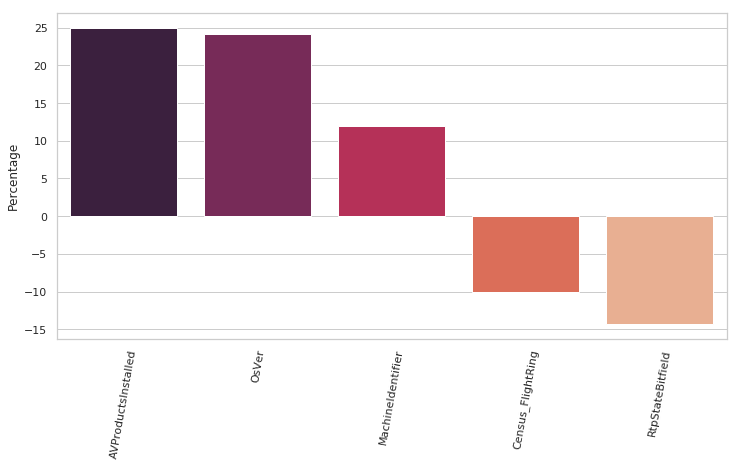

In [7]:
cat_increase = join_stats[join_stats['% changed'] > 10]
cat_decrease = join_stats[join_stats['% changed'] < -10]
cat_change = cat_increase.append(cat_decrease).sort_values('% changed', ascending=False)
display(cat_change)

f, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x=cat_change['Feature'].values, y=cat_change['% changed'].values, palette="rocket")
ax.set_ylabel("Percentage")
plt.xticks(rotation=80)
plt.show()

In [8]:
del test_stats, join_stats, cat_increase, cat_decrease, test
gc.collect()

11254

## Binary features EDA

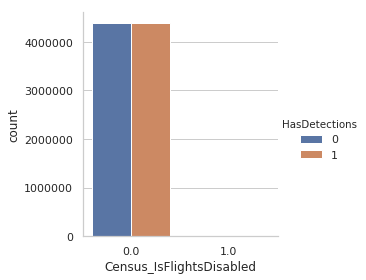

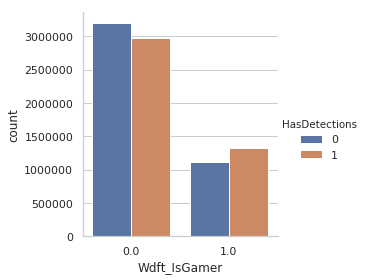

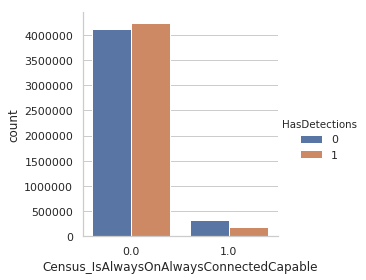

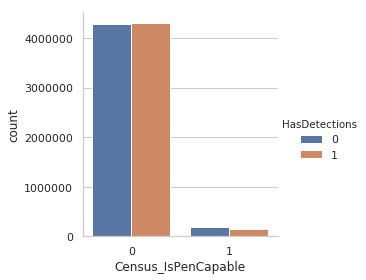

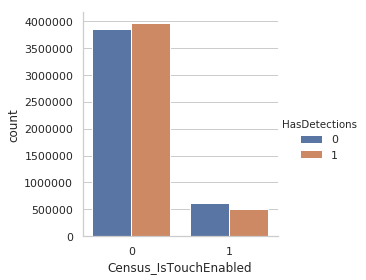

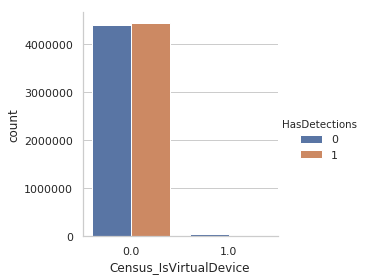

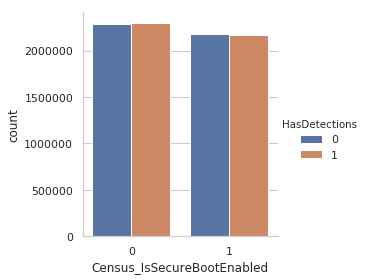

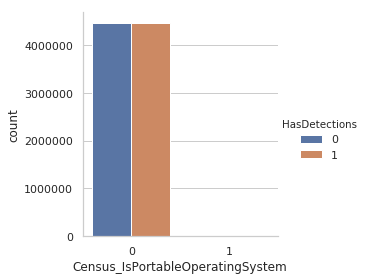

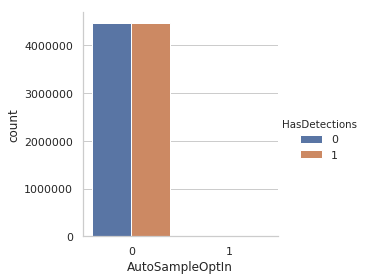

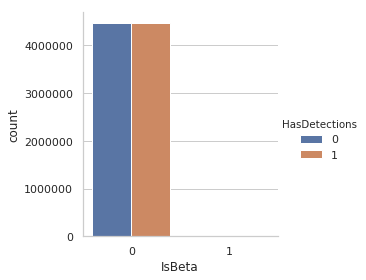

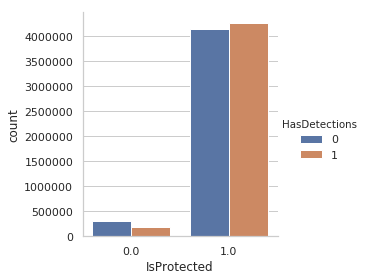

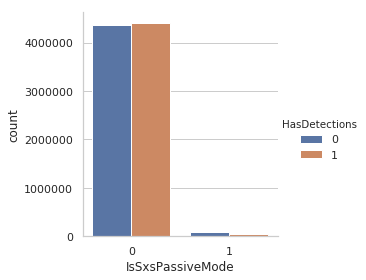

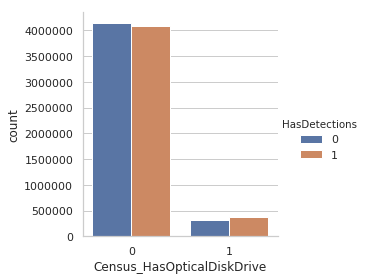

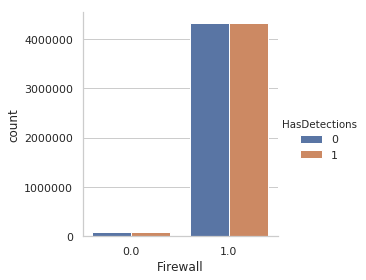

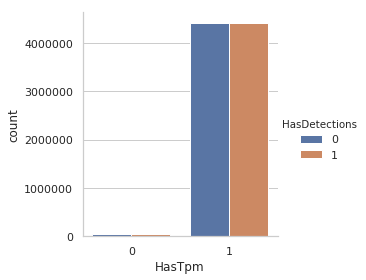

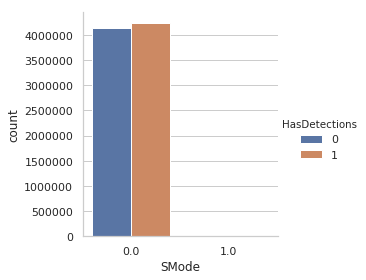

In [9]:
binary_features = list(train_stats[train_stats['Type'] == 'Binary']['Feature'])
for feature in binary_features:
    if feature != 'HasDetections':
        sns.catplot(x=feature, hue='HasDetections', data=train, kind='count', height=4)

Some of the features have almost the same distribution on the label, then we should probably remove: **IsBeta, HasTpm, AutoSampleOptIn, SMode, Firewall, Census_HasOpticalDiskDrive, Census_IsPortableOperatingSystem, Census_IsFlightsDisabled, Census_IsSecureBootEnabled, Census_IsPenCapable**.

## Numerical features EDA

### Box plots
* For each feature there are two plots for better visualization, one with all data, and other with only values between the 5 and 95 percentiles.

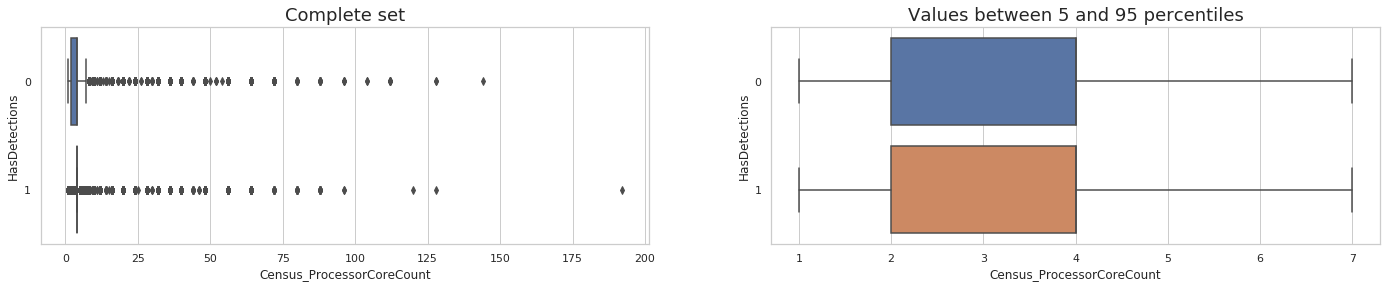

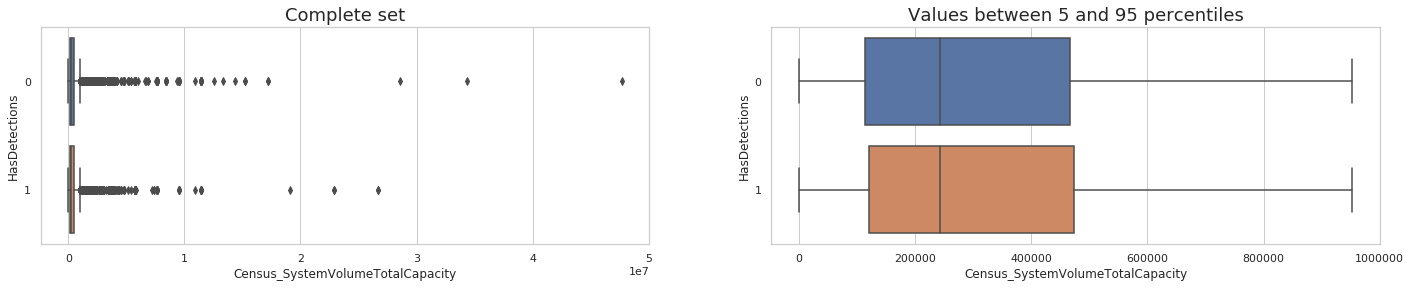

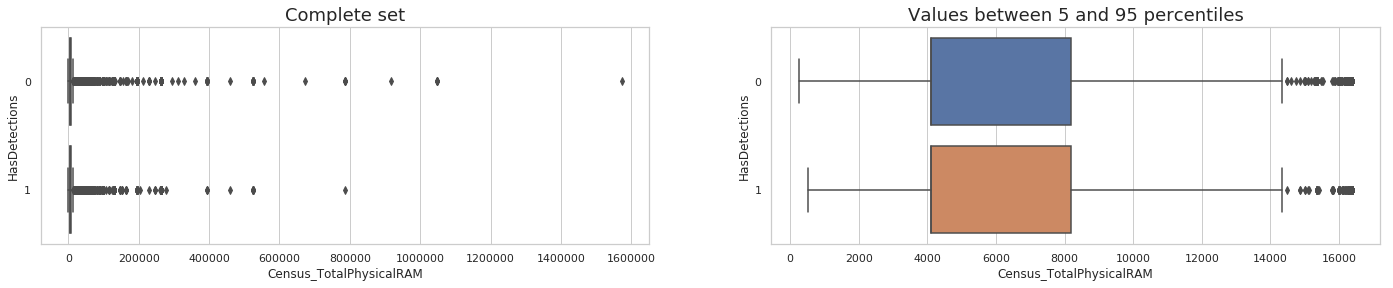

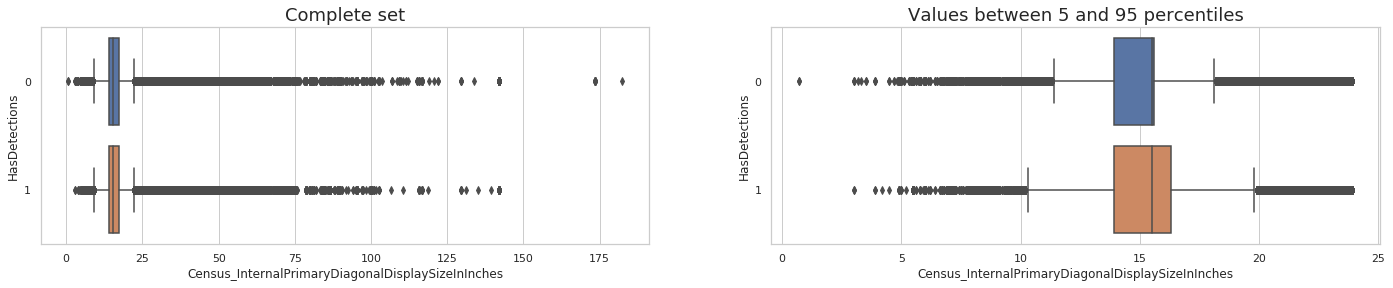

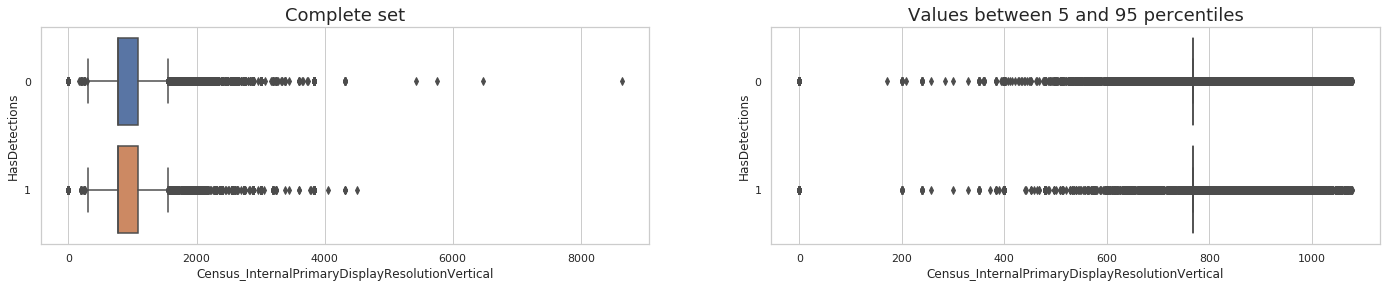

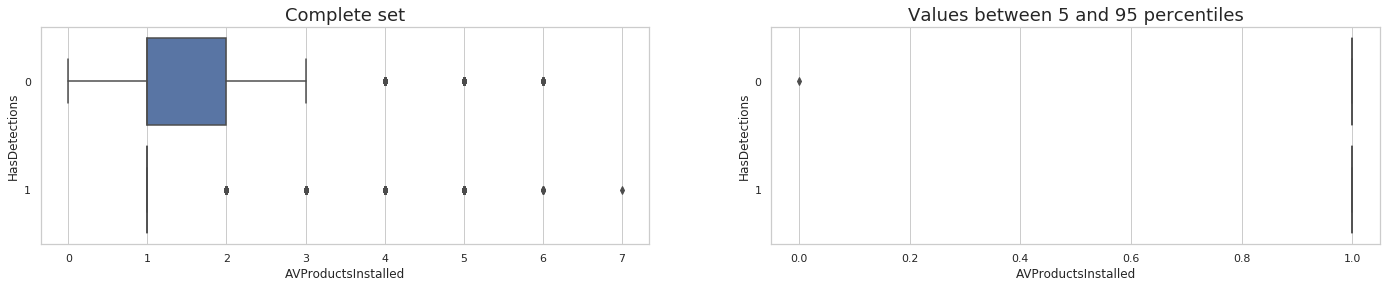

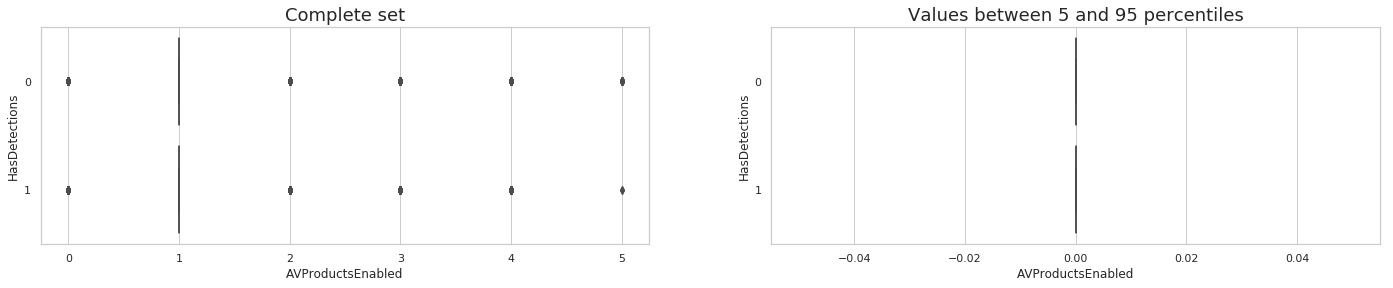

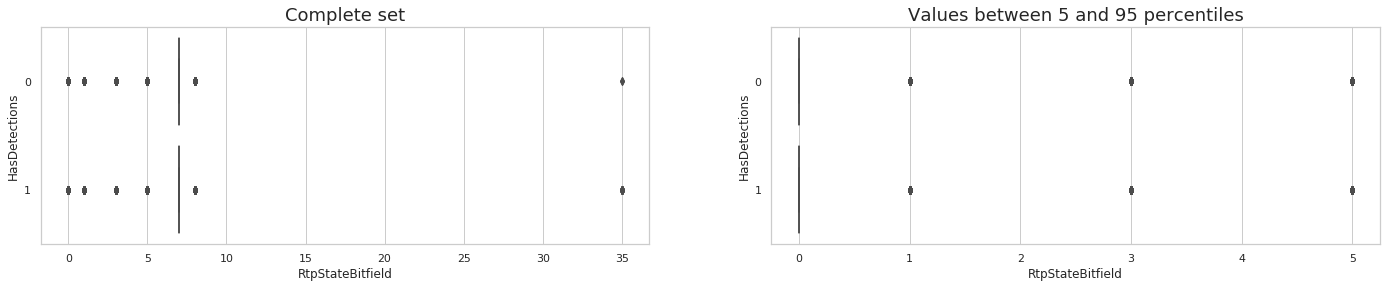

In [10]:
numeric_features = ['Census_ProcessorCoreCount',
                    'Census_SystemVolumeTotalCapacity',
                    'Census_TotalPhysicalRAM',
                    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                    'Census_InternalPrimaryDisplayResolutionVertical',
                    'AVProductsInstalled',
                    'AVProductsEnabled',
                    'RtpStateBitfield']

for feature in numeric_features:
    trimmed_df = train[train[feature] < train[feature].quantile(0.95)]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 4))
    sns.boxplot(y="HasDetections", x=feature, data=train, orient='h', ax=ax1).set_title("Complete set", fontsize=18)
    if len(trimmed_df) > 0:
        sns.boxplot(y="HasDetections", x=feature, data=trimmed_df, orient='h', ax=ax2).set_title("Values between 5 and 95 percentiles", fontsize=18)
    plt.show()

### Scatter matrix
* Things get a little difficult here since this kind of scatter plot isn't very useful with big data, but the distribution plots may help with the understanding.

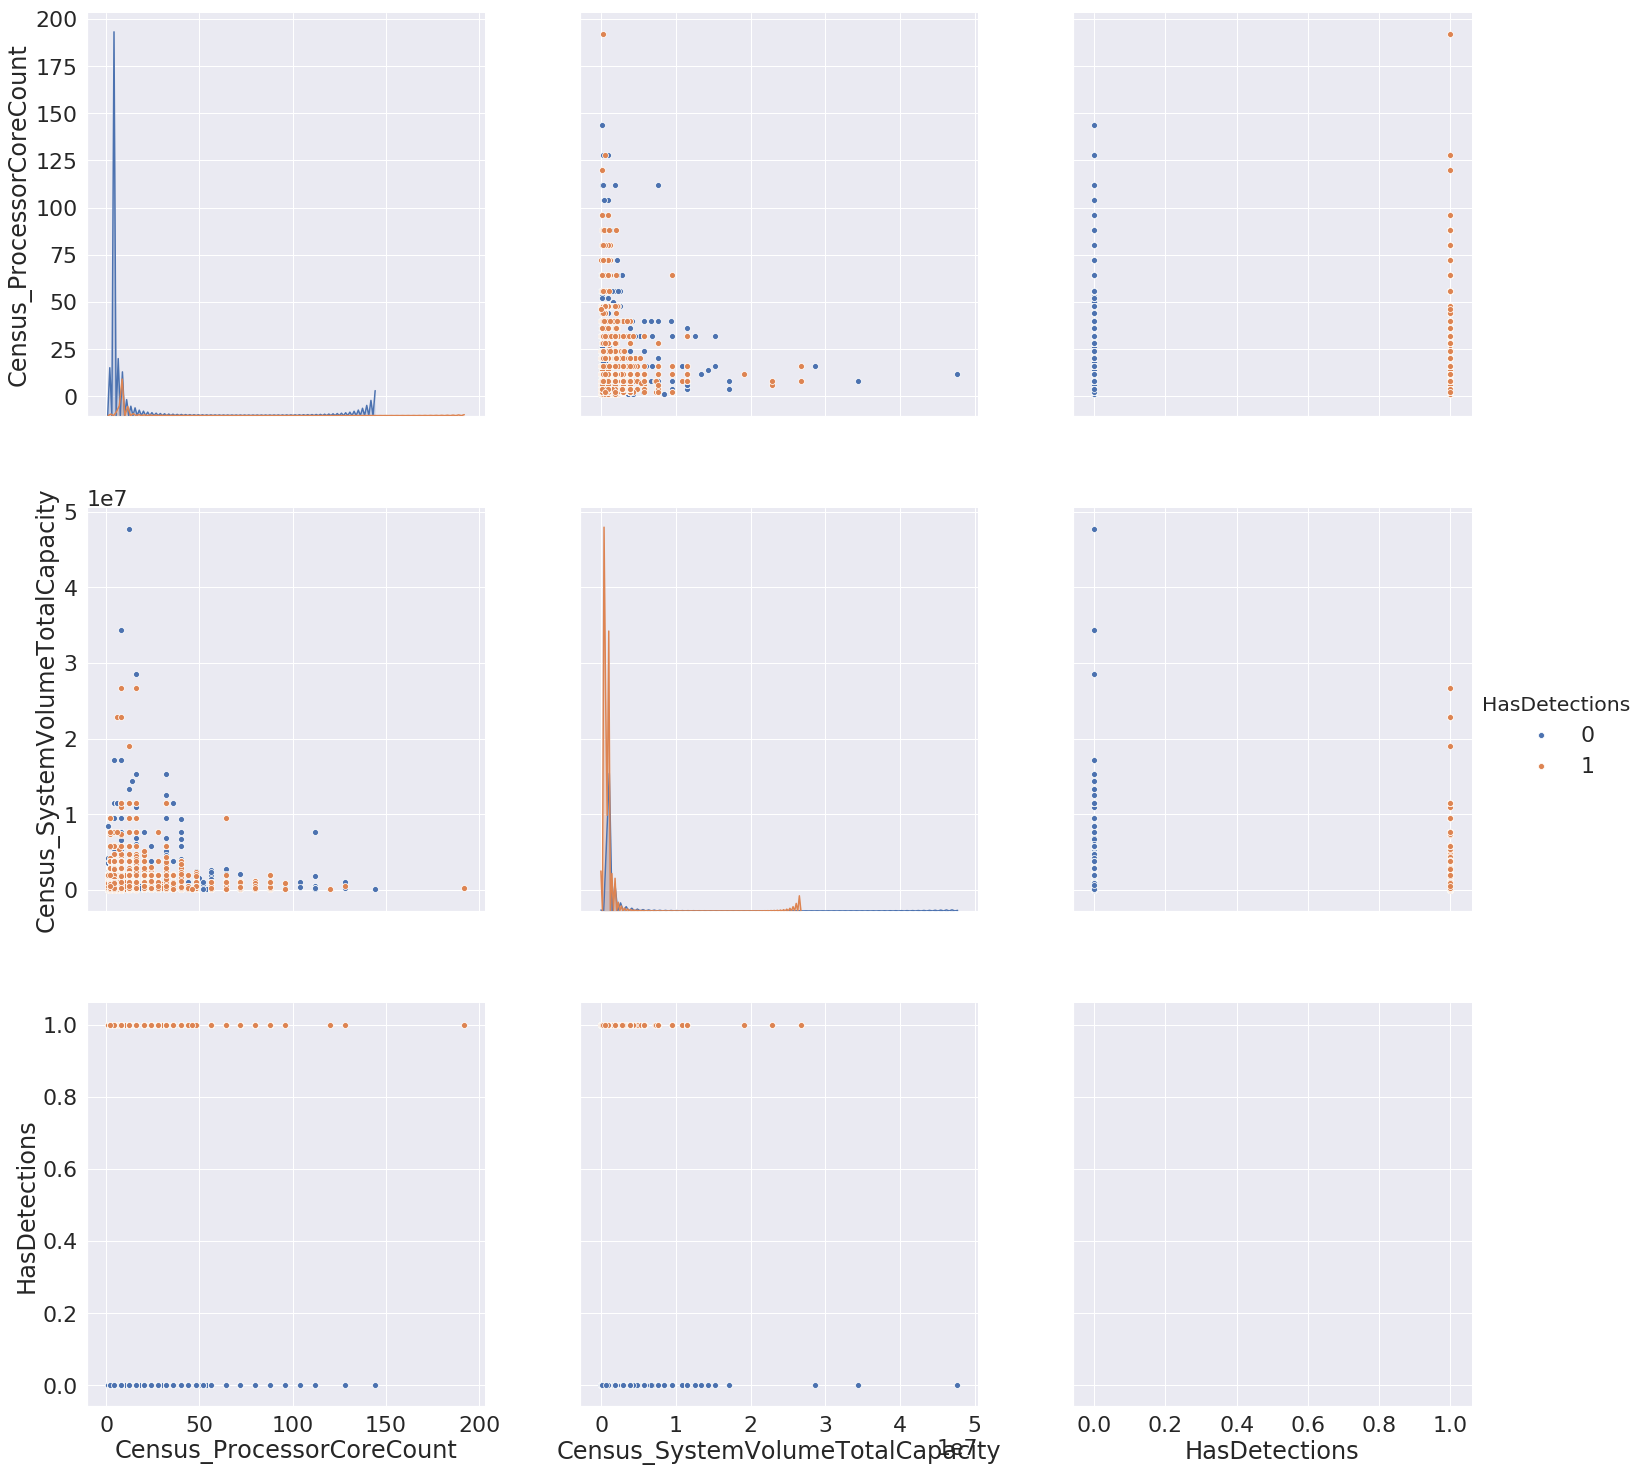

In [11]:
# Break plots in parts
fifth_cols = len(numeric_features) // 4
cols1 = list(numeric_features[:fifth_cols]) + ['HasDetections']
cols2 = list(numeric_features[fifth_cols:fifth_cols*2]) + ['HasDetections']
cols3 = list(numeric_features[fifth_cols*2:fifth_cols*3]) + ['HasDetections']
cols4 = list(numeric_features[fifth_cols*3:]) + ['HasDetections']

sns.set(style="ticks")
sns.set(font_scale=2)
sns.pairplot(train[cols1], hue="HasDetections", height=7)
plt.show()

Here "Census_ProcessorCoreCount" is interesting since it has most target 0 values on the beginning of the distribution.

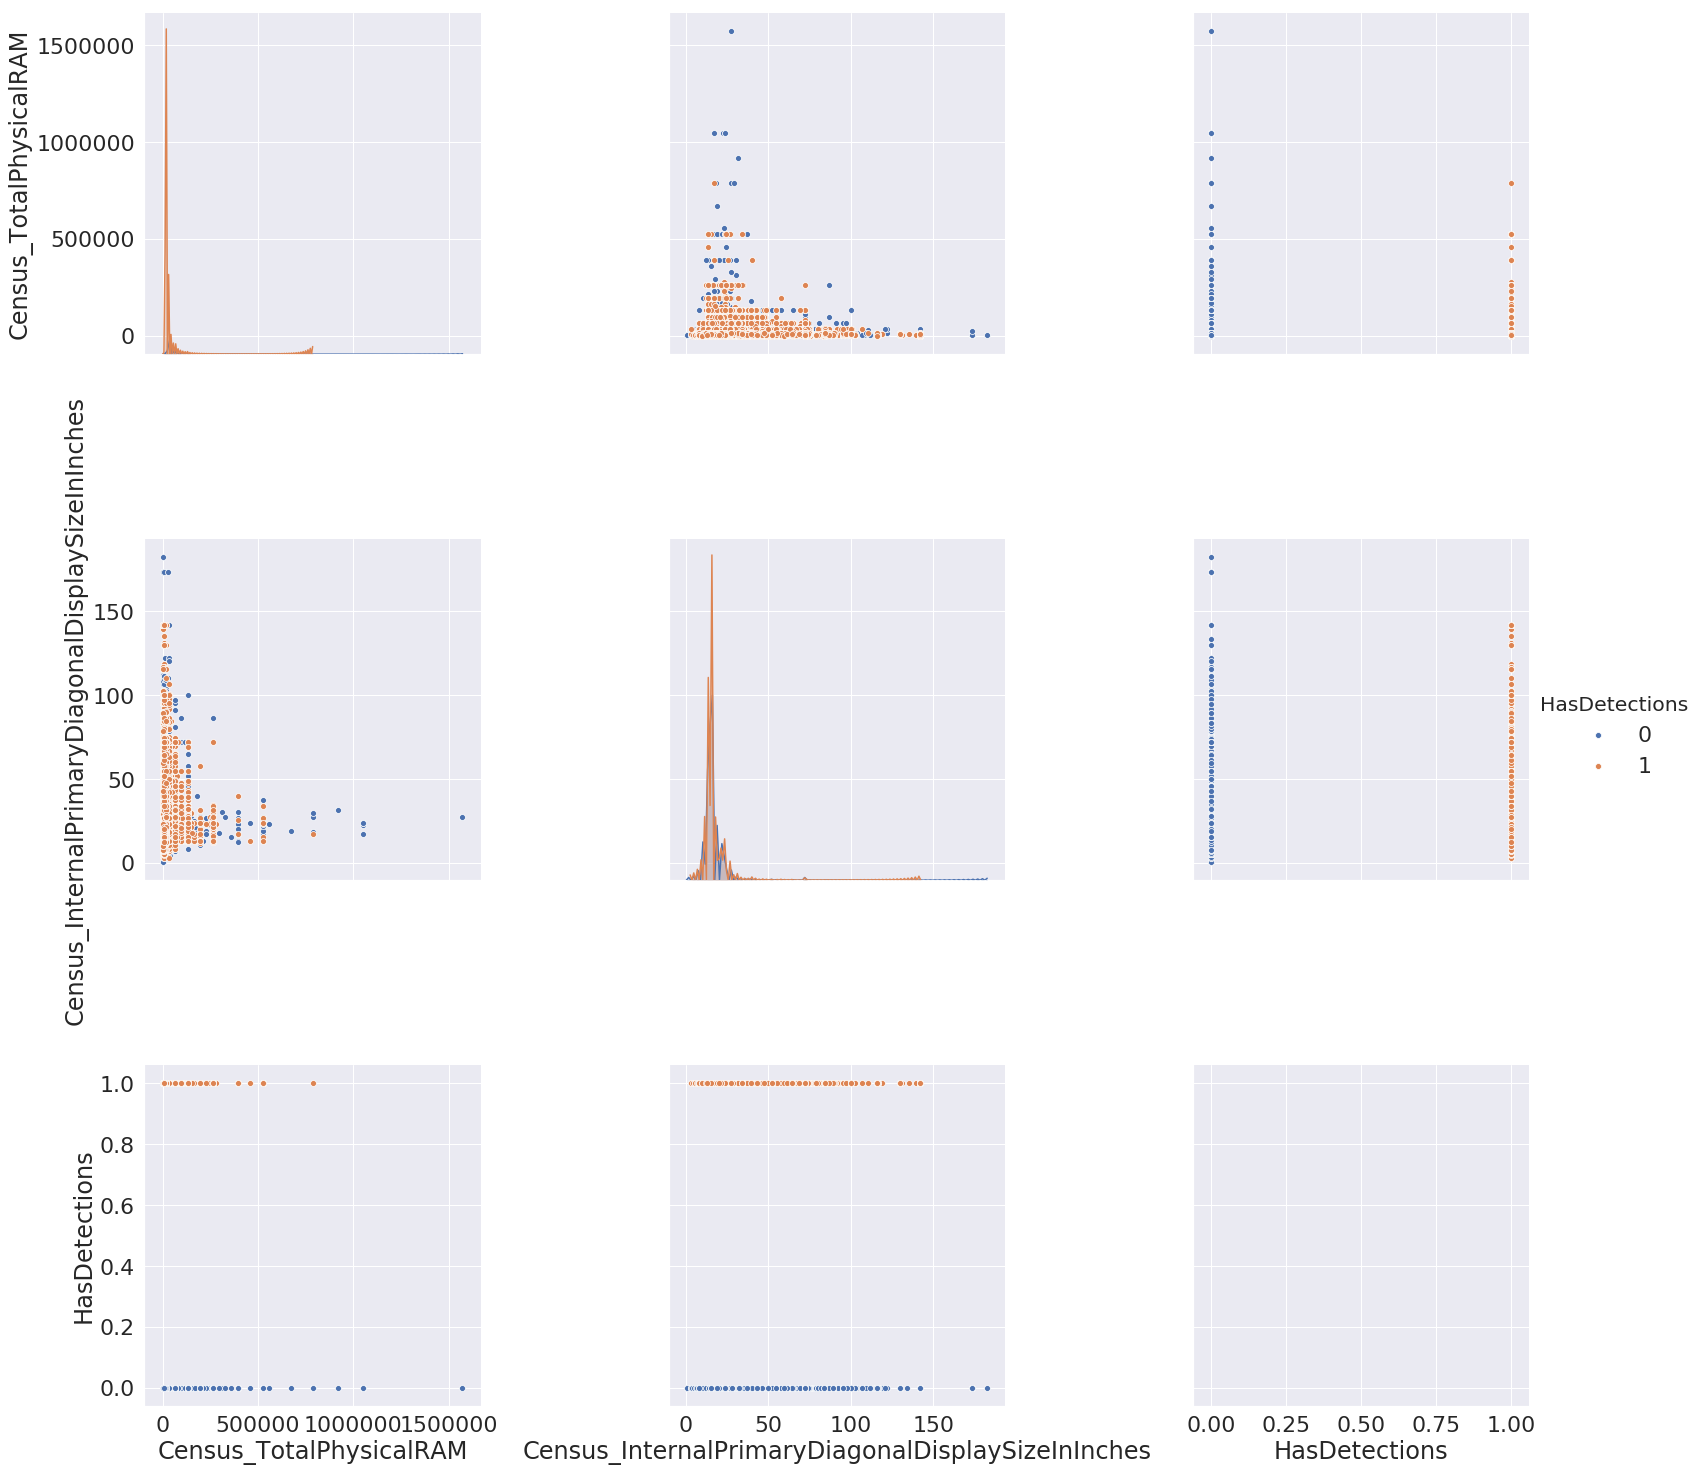

In [12]:
sns.pairplot(train[cols2], hue="HasDetections", height=7)
plt.show()

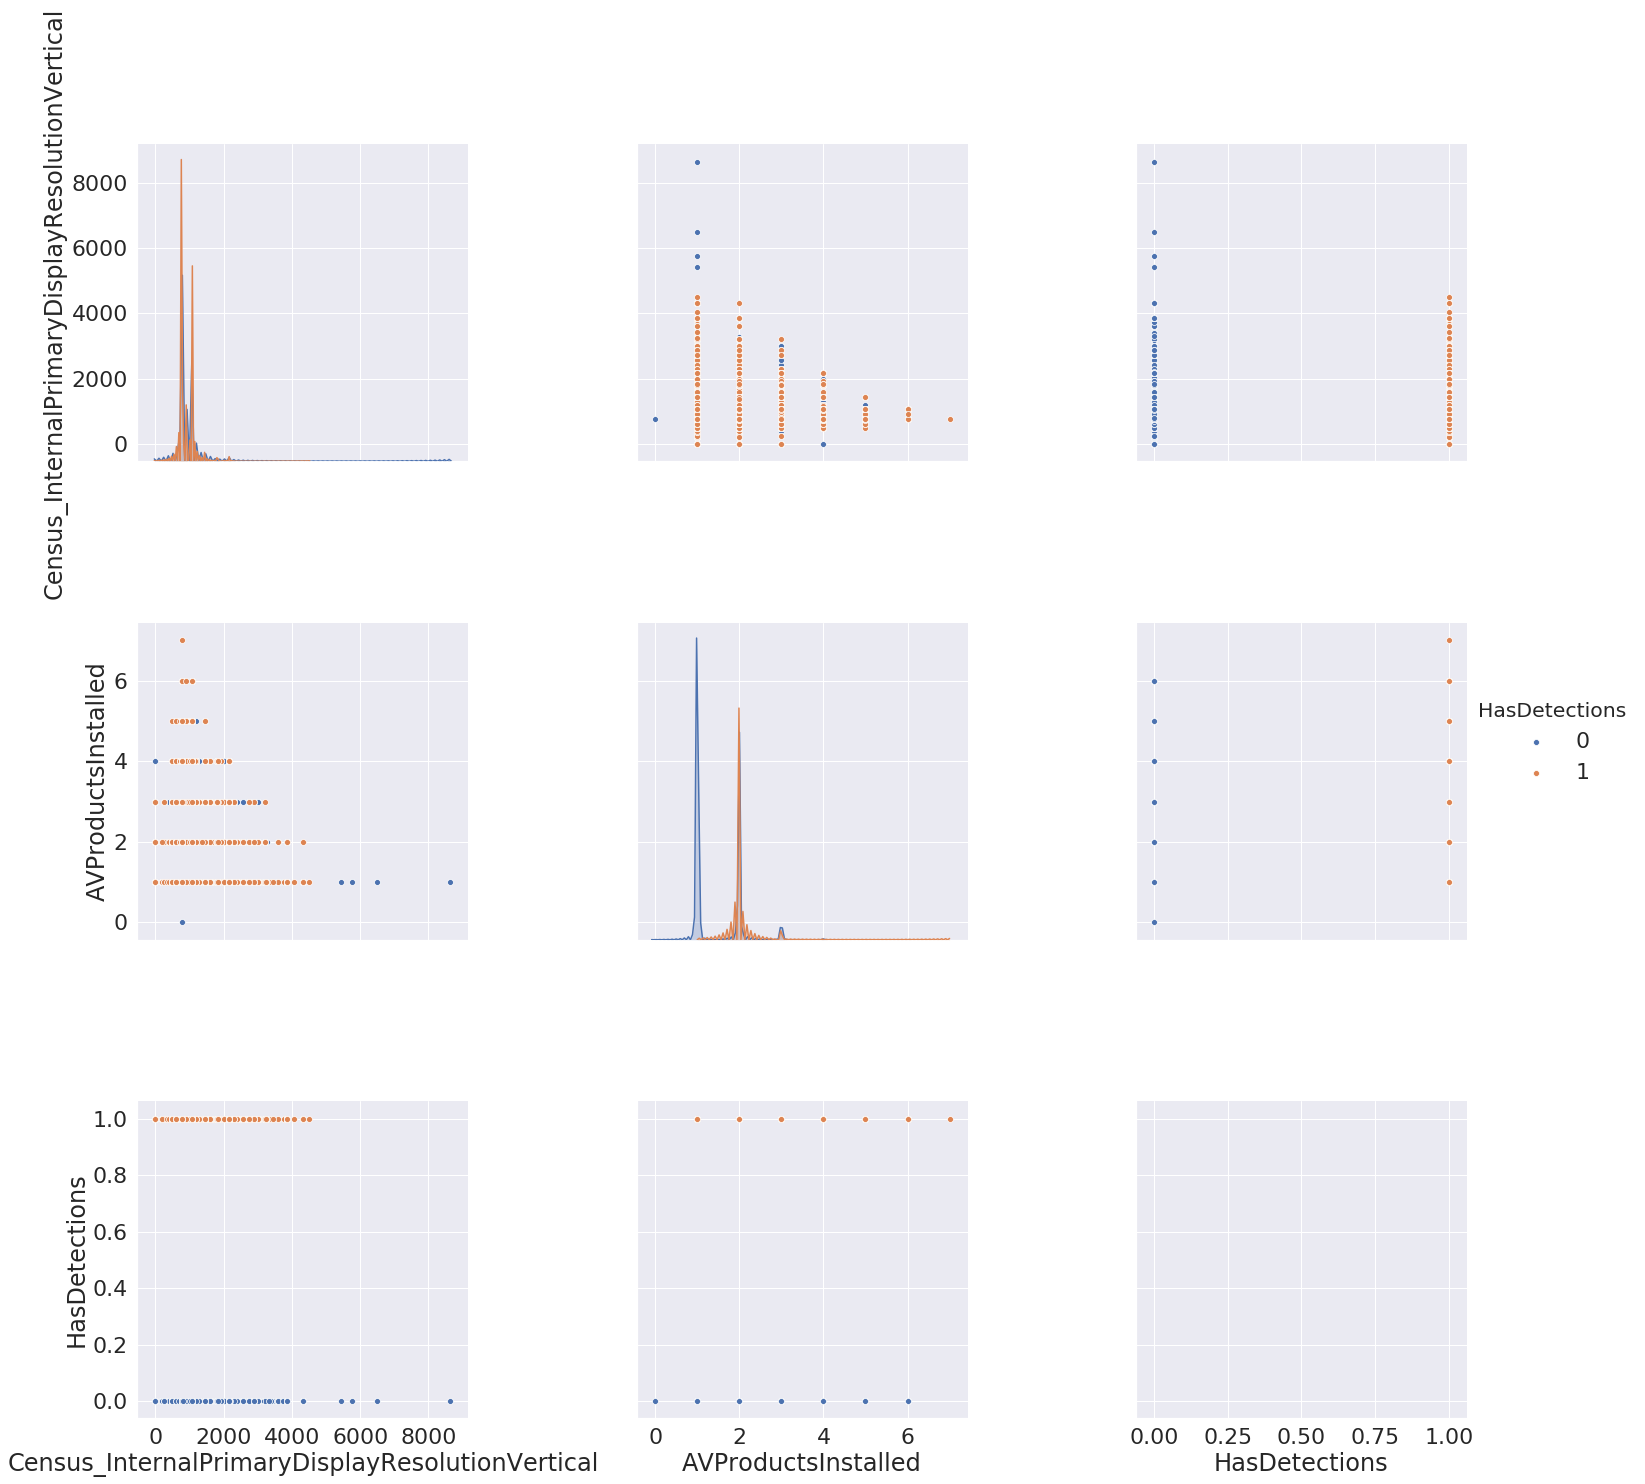

In [13]:
sns.pairplot(train[cols3], hue="HasDetections", height=7)
plt.show()

"AVProductsInstalled" seems to be very useful, as you can see the target feature has a different distribution of it's values.

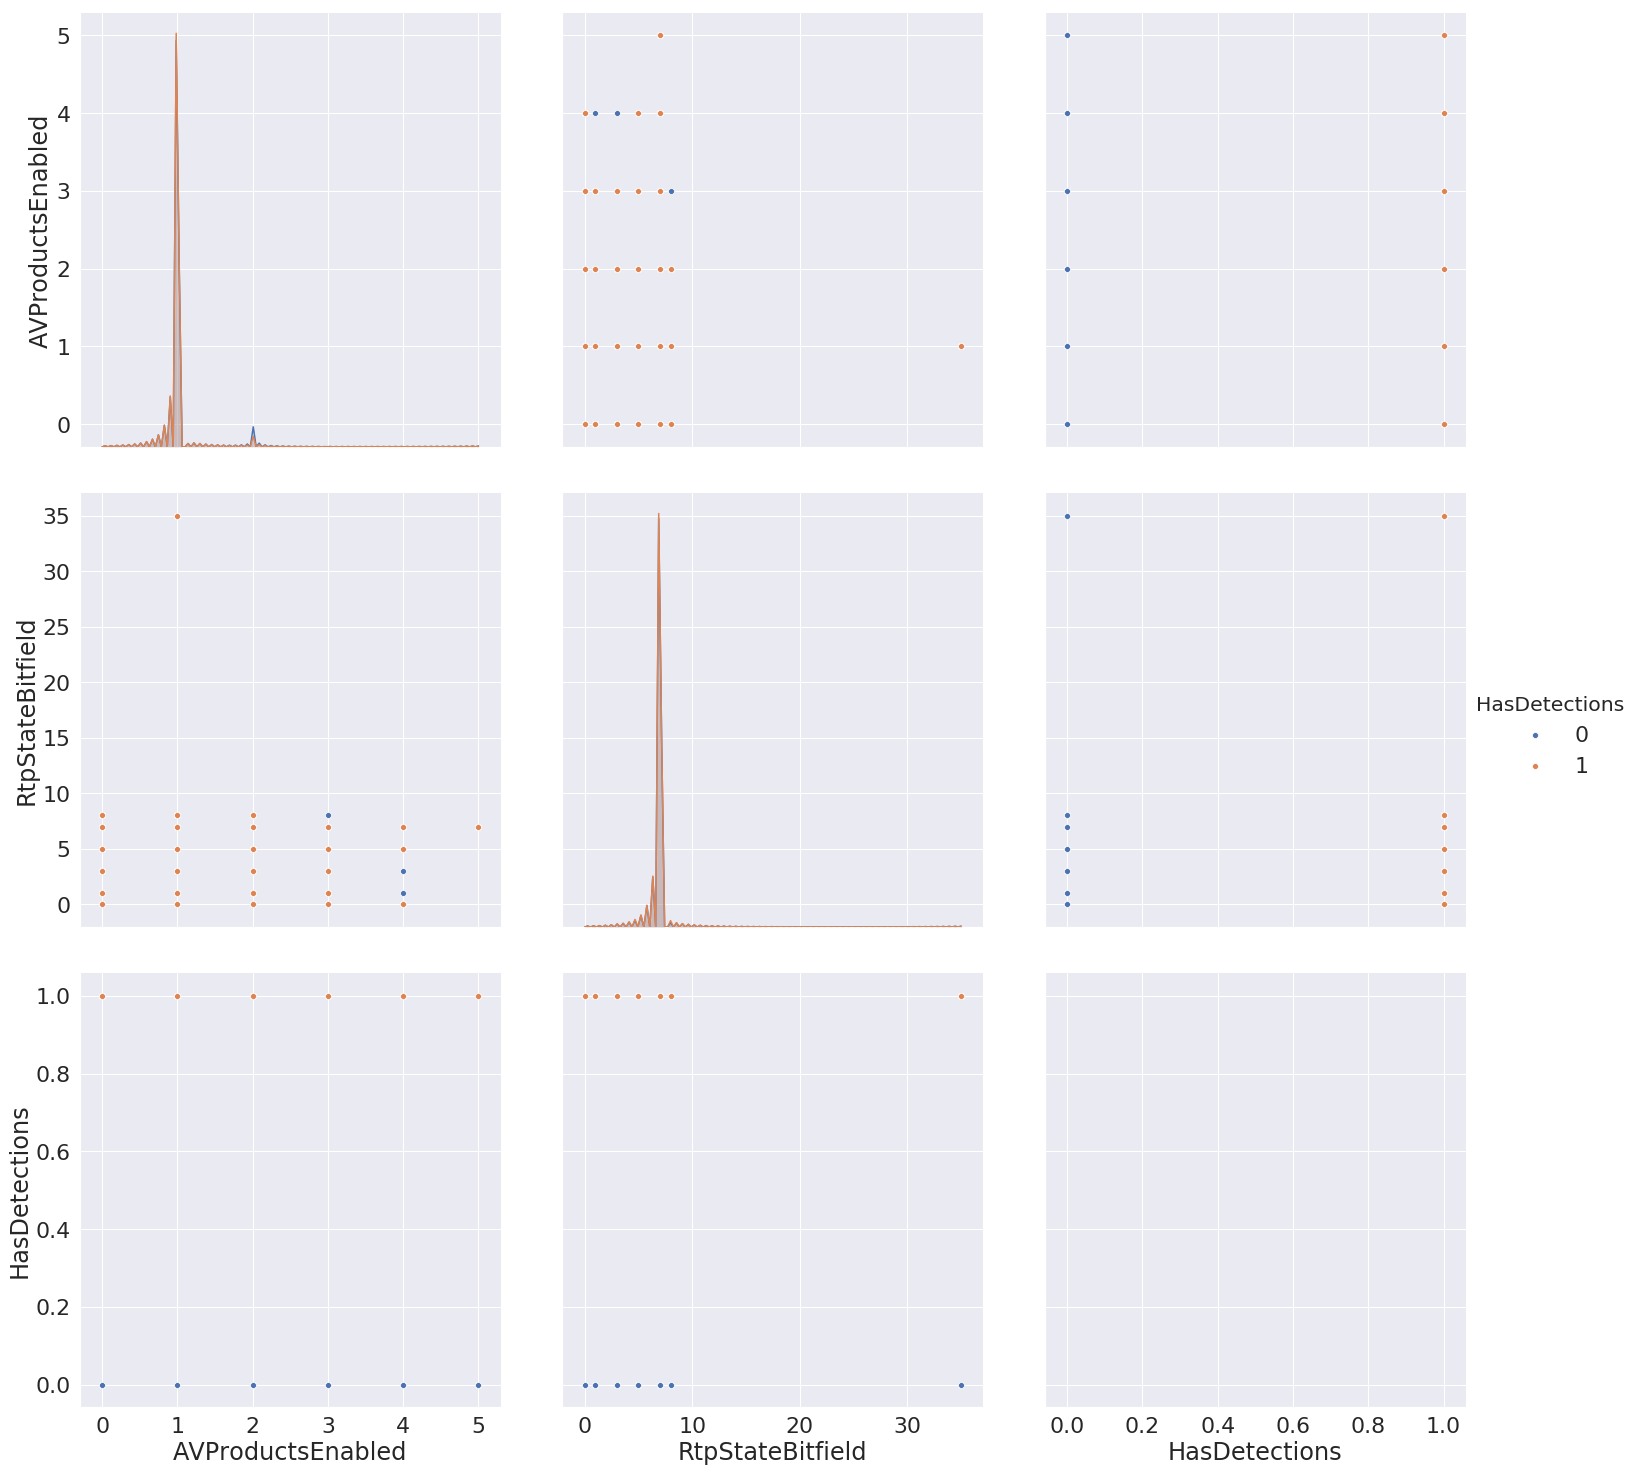

In [14]:
sns.pairplot(train[cols4], hue="HasDetections", height=7)
plt.show()

Doesn't seems to be going anything really interesting with all the other distributions.

### Correlation matrix

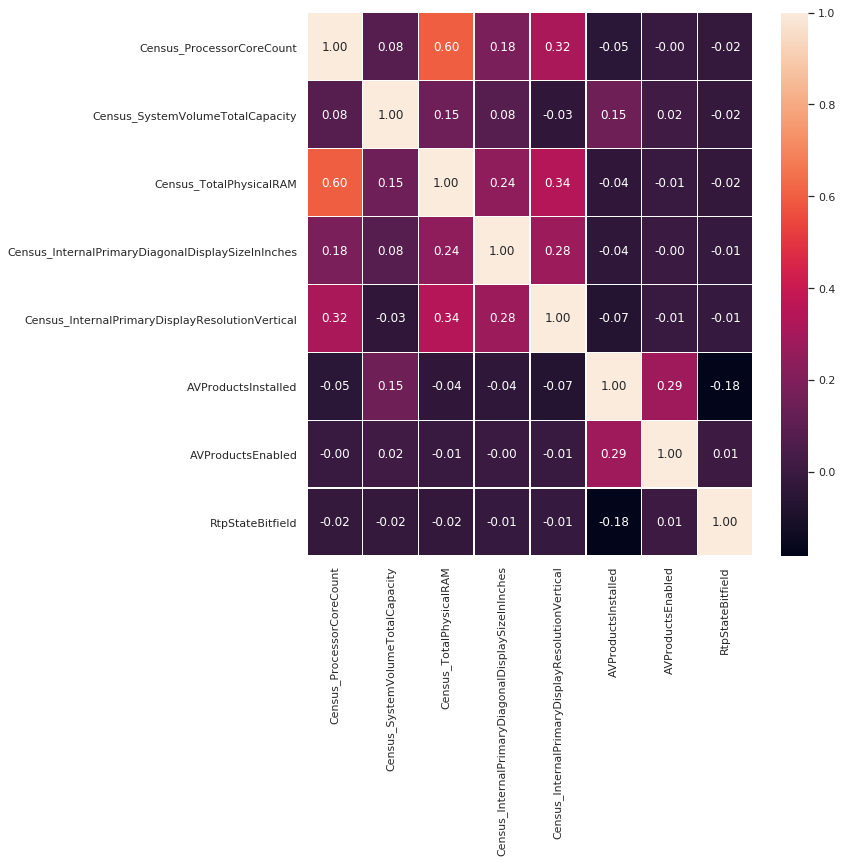

In [15]:
corrs = train[numeric_features].corr()
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrs, annot=True, linewidths=.5, fmt=".2f", ax=ax)
plt.show()

Unfortunately doesn't seems to be any big correlation between the label and any variable, the greater correlation is with "AVProductsInstalled", makes sense since with more antivirus products less are the chances to be infected with a malware.

Some feature may be a little redundant, like "Census_TotalPhysicalRAM" and "Census_ProcessorCoreCount", probably because if you have more RAM you may have a larger computer, so more cores as well.

## Train/validation split EDA

In [16]:
test = dd.read_csv('../input/microsoft-malware-prediction/test.csv', dtype=dtypes, usecols=use_columns).compute()

# IMPORT TIMESTAMP DICTIONARY
datedict = np.load('../input/malware-timestamps/AvSigVersionTimestamps.npy')
datedict = datedict[()]
# ADD TIMESTAMPS
train['Date'] = train['AvSigVersion'].map(datedict)
test['Date'] = test['AvSigVersion'].map(datedict)

train.drop('AvSigVersion', axis=1, inplace=True)
test.drop('AvSigVersion', axis=1, inplace=True)

print('Train set shape', train.shape)
print('Test set shape', test.shape)
train.head()

Train set shape (8921483, 62)
Test set shape (7853253, 61)


,MachineIdentifier,ProductName,EngineVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Date
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,0,7.0,0,1.0,1.0,1,29,18.0,35.0,-85,windows10,x64,10.0.0.0,256,rs4,Pro,1.0,0,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,4.0,5.0,HDD,299451.0,0,4096.0,Desktop,18.906250,900.0,Desktop,10.0.17134.165,amd64,rs4_release,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,0.0,Retail,0,0.0,0,0,0.0,0.0,10.0,0,2018-08-20 21:11:00
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,0,7.0,0,1.0,1.0,1,93,18.0,119.0,64,windows10,x64,10.0.0.0,256,rs4,Pro,1.0,0,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,4.0,5.0,HDD,102385.0,0,4096.0,Notebook,13.898438,768.0,Mobile,10.0.17134.1,amd64,rs4_release,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,0.0,NOT_SET,0,0.0,0,0,0.0,0.0,8.0,0,2018-03-01 22:10:00
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,0,7.0,0,1.0,1.0,1,86,18.0,64.0,49,windows10,x64,10.0.0.0,768,rs4,Home,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4.0,5.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1080.0,Desktop,10.0.17134.165,amd64,rs4_release,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.0,Retail,0,0.0,0,0,0.0,0.0,3.0,0,2018-08-13 23:35:00
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,0,7.0,0,1.0,1.0,1,88,NaN,117.0,115,windows10,x64,10.0.0.0,256,rs4,Pro,1.0,0,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,4.0,5.0,UNKNOWN,227116.0,0,4096.0,MiniTower,18.500000,768.0,Desktop,10.0.17134.228,amd64,rs4_release,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.0,Retail,0,0.0,0,0,0.0,0.0,3.0,1,2018-08-17 03:01:00
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,0,7.0,0,1.0,1.0,1,18,NaN,277.0,75,windows10,x64,10.0.0.0,768,rs4,Home,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,4.0,5.0,HDD,101900.0,0,6144.0,Portable,14.000000,768.0,Mobile,10.0.17134.191,amd64,rs4_release,191,Core,CORE,Update,8.0,31,FullAuto,0,IS_GENUINE,Retail,0.0,Retail,0,0.0,0,0,0.0,0.0,1.0,1,2018-08-14 12:33:00


In [17]:
print('Train set min date', train['Date'].min().date())
print('Train set max date', train['Date'].max().date())
print('Test set min date ', test['Date'].min().date())
print('Test set max date ', test['Date'].max().date())

Train set min date 2013-07-18
Train set max date 2018-09-25
Test set min date  2013-07-18
Test set max date  2018-11-25


### Machine IDs distribution by month

In [18]:
train['Date'] = pd.to_datetime(train['Date'],).dt.strftime('%Y-%m')
test['Date'] = pd.to_datetime(test['Date'],).dt.strftime('%Y-%m')

df_train = train.groupby('Date', as_index=False)['MachineIdentifier'].count()
df_test = test.groupby('Date', as_index=False)['MachineIdentifier'].count()
train_test = pd.merge(df_train, df_test, how='outer', on='Date', suffixes=('_train', '_test')).set_index('Date')
train_test.fillna(0, inplace=True)

train_test.iplot(kind='bar', xTitle='Date', yTitle='Count', title='Monthly machine count')

It seems that the test set have a different max date than the train set, also most of the data the train and test sets are accumulated on the last 3 months, but train and test set have IDs across almost all years and months, it might be a good idea to leave the last 1 or 2 months from the train set as validation, and maybe add a few randomly distributed IDs to this validation set as well.

### Label distribution by month

In [19]:
df_train2 = train.groupby('Date', as_index=False)['HasDetections'].sum().set_index('Date')
df_train2.iplot(kind='bar', xTitle='Date', yTitle='Count', title='Monthly malware detection')

Most of the malware detection are on the last months, this is no surprise as most of the data are also on those months.

### Unique IDs on data sets

In [ ]:
n_train_unique_ids = train['MachineIdentifier'].nunique()
n_test_unique_ids = test['MachineIdentifier'].nunique()
train_unique_ids = set(train['MachineIdentifier'].unique())
test_unique_ids = set(test['MachineIdentifier'].unique())
train_only_ids = list(train_unique_ids - test_unique_ids)
test_only_ids = list(test_unique_ids - train_unique_ids)
both_set_ids = list(train_unique_ids & test_unique_ids)
ids_df = pd.DataFrame([(len(train_only_ids), 'Train only ids'), (len(test_only_ids), 'Test only ids'), (len(both_set_ids), 'Both sets ids')], columns=['values', 'labels'])

print('IDs only in train set:', len(train_only_ids))
print('IDs only in test set:', len(test_only_ids))
print('IDs in both sets:', len(both_set_ids))
ids_df.iplot(kind='pie',labels='labels',values='values')

There is no ID both on train and test set, this may make things easier as we don't need to care about ID distribution on train and validation sets.